In [15]:
import os
import time
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
import faiss

In [2]:
model_name = "Facenet"
detector_backend = "mtcnn"
num_dimensions = 128 # Facenet output

 # Facial database

In [3]:
representations = []
for r, d, files in os.walk("deepface/tests/dataset/"):
    for file in files:
        if ".jpg" in file:
            exact_file = f"{r}{file}"
            objs = DeepFace.represent(
                img_path=exact_file,
                model_name=model_name,
                detector_backend=detector_backend
            )
            for obj in objs:
                embedding = obj["embedding"]
                representations.append([file, embedding])

In [8]:
print(f"deepface unit test items have {len(representations)} images")

deepface unit test items have 1000000 images


# Synthetic images

In [5]:
for i in range(len(representations), 1000000):
    key = f"synthetic_{i}.jpg"
    vector = [random.gauss(-0.5, 0.5) for z in range(num_dimensions)]
    representations.append([key, vector])

In [9]:
print(f"after adding synthetic data, we have {len(representations)} items")

after adding synthetic data, we have 1000000 items


In [7]:
embeddings = []
for key, value in representations:
    embeddings.append(value)

# initialize faiss

In [10]:
# euclidean
tic = time.time()
index = faiss.IndexFlatL2(num_dimensions)
toc = time.time()
print(f"faiss instance is initialized in {toc-tic} seconds")

faiss instance is initialized in 9.202957153320312e-05 seconds


In [11]:
# add 1M sized facial database into faiss
tic = time.time()
index.add(np.array(embeddings, dtype = "f"))
toc = time.time()
print(f"{len(embeddings)} vectors stored in faiss intance in {toc-tic} seconds")

1000000 vectors stored in faiss intance in 5.398401975631714 seconds


# target image

In [12]:
target_path = "target.jpg"

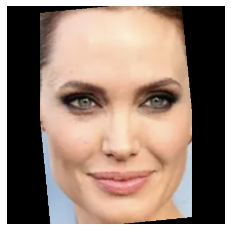

In [48]:
target_img = DeepFace.extract_faces(
    img_path = target_path, 
    detector_backend=detector_backend
)[0]["face"]
plt.imshow(target_img)
plt.axis("off")
plt.show()

In [21]:
target_embedding = DeepFace.represent(
    img_path=target_path,
    model_name=model_name,
    detector_backend=detector_backend
)[0]["embedding"]

In [22]:
target_embedding = np.array(target_embedding, dtype = "f")

In [23]:
target_embedding = np.expand_dims(target_embedding, axis = 0)

In [24]:
target_embedding.shape

(1, 128)

# search

In [25]:
k = 3
tic = time.time()
distances, neighbours = index.search(target_embedding, k)
toc = time.time()
print(f"search completed in {toc - tic} in seconds")

search completed in 0.03743577003479004 in seconds


1th closest image in 1000000 database


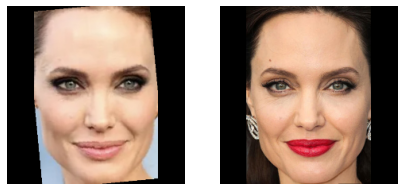

2th closest image in 1000000 database


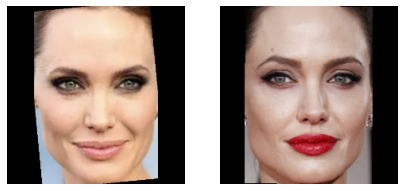

3th closest image in 1000000 database


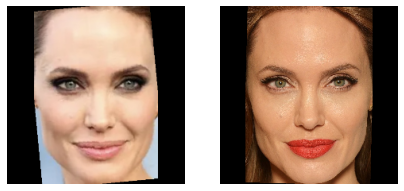

In [51]:
for idx, neighbour in enumerate(neighbours[0]):
    neighbour_name = representations[neighbour][0]
    
    neighbour_img = DeepFace.extract_faces(
        img_path=f"deepface/tests/dataset/{neighbour_name}",
        detector_backend=detector_backend
    )[0]["face"]
    
    print(f"{idx+1}th closest image in {len(embeddings)} database")
    fig = plt.figure(figsize=(7, 7))
    
    fig.add_subplot(1,2,1)
    plt.imshow(target_img)
    plt.axis("off")
    
    fig.add_subplot(1,2,2)
    plt.imshow(neighbour_img)
    plt.axis("off")
    
    plt.show()